In [1]:
# Step 1: Google Colab and Kaggle Setup
# -----------------------------------------
# 1. Mount Google Drive: UNCOMMENT the two lines below to save your model to Google Drive.
from google.colab import drive
drive.mount('/content/drive')

# 2. Install Kaggle API
!pip install -q kaggle

# 3. Upload your kaggle.json file
# How to Get Your kaggle.json File
# -Log in to your Kaggle account.
# -Navigate to your Account settings by clicking on your profile picture in the top-right corner and selecting "Settings."
# -Scroll down to the API section.
# -Click on the "Create New API Token" button. This will immediately trigger the download of the kaggle.json file to your computer.

from google.colab import files
print("Please upload your kaggle.json file")
files.upload()

# 4. Configure Kaggle and Download Dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d landlord/handwriting-recognition
!unzip -q handwriting-recognition.zip -d handwriting_data

Mounted at /content/drive
Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/landlord/handwriting-recognition
License(s): CC0-1.0
100% 1.26G/1.26G [00:05<00:00, 257MB/s]
100% 1.26G/1.26G [00:05<00:00, 243MB/s]


In [2]:
# Setting up MLFlow and NgGrok.

# Setting the authtoken to be able to connect to your NGrok account.
# Please replace below AUTH_TOKEN with your own your Ngrok account.
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "xxxxx"

!pip install mlflow pyngrok torchmetrics

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

# create remote tunnel using ngrok.com to allow local port access
from pyngrok import ngrok

# Terminate open tunnels if they exist
ngrok.kill()

# Setting up auth token
ngrok.set_auth_token(NGROK_AUTH_TOKEN) # Removed to avoid potential conflicts with existing sessions

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr = "5000", proto = "http", bind_tls = True)

print("MLflow Tracking UI:", ngrok_tunnel.public_url)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
#import necessary libraries
# -----------------------------------------
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchmetrics.functional import accuracy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from PIL import Image

import mlflow
import mlflow.pytorch
import mlflow.artifacts
from mlflow.tracking import MlflowClient
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [4]:
# Configuration and Hyperparameters
# -----------------------------------------
import pandas as pd
import os

class Config:

    DATA_DIR = './handwriting_data/'
    TRAIN_CSV_PATH = os.path.join(DATA_DIR, 'written_name_train_v2.csv')
    VALIDATION_CSV_PATH = os.path.join(DATA_DIR, 'written_name_validation_v2.csv')
    TEST_CSV_PATH = os.path.join(DATA_DIR, 'written_name_test_v2.csv')

    # After mounting your drive, this path will point to a folder where the model is saved.
    # For example: '/content/drive/MyDrive/MyModels/handwriting_model.pth'
    # If you don't mount Google Drive, it will save to the Colab environment.
    MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab/Models/handwriting_crnn_model.pth'

    # Experiment name to be used, if this experiment name isn't there in your MLFlow, it will train the model.
    # To force a new training, give a new Expeiment name
    EXPERIMENT_NAME = 'CRNN_Handwriting_Hyperopt_Full_Experiment'

    # Enable training of data on limited data instead of full dataset
    ENABLE_TRAINING_ON_LIMITED_DATASET = True

    # Image parameters
    IMG_HEIGHT = 64
    IMG_WIDTH = 256

    # Model parameters
    BATCH_SIZE = 64
    EPOCHS = 20
    HYPEROPT_EVALS = 15

    # Configuration to use for limited data taining
    LIMITED_DATA_EPOCHS = 20
    LIMITED_DATA_HYPEROPT_EVALS = 3

    # Character set
    # Dynamically build the character set from the dataset labels
    def build_char_set(self):
        all_chars = set()
        try:
            train_df = pd.read_csv(self.TRAIN_CSV_PATH).dropna()
            val_df = pd.read_csv(self.VALIDATION_CSV_PATH).dropna()
            test_df = pd.read_csv(self.TEST_CSV_PATH).dropna()

            for label in train_df['IDENTITY']:
                all_chars.update(str(label))
            for label in val_df['IDENTITY']:
                 all_chars.update(str(label))
            for label in test_df['IDENTITY']:
                 all_chars.update(str(label))

        except FileNotFoundError:
            print("Warning: Dataset CSV files not found. Using a default character set.")
            all_chars = set(" !\"#&'()*+,-./0123456789:;?@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")


        # Sort characters to ensure consistent mapping
        sorted_chars = sorted(list(all_chars))
        # The character set should include all possible characters in the labels
        # plus a blank character for CTC loss, which is usually at index 0
        self.CHAR_SET = "".join(sorted_chars)
        self.CHAR_TO_INT = {char: i + 1 for i, char in enumerate(self.CHAR_SET)}
        self.INT_TO_CHAR = {i + 1: char for i, char in enumerate(self.CHAR_SET)}
        self.VOCAB_SIZE = len(self.CHAR_SET) + 1 # +1 for the blank token

# Instantiate the config and build the character set
config = Config()
config.build_char_set()

if (config.ENABLE_TRAINING_ON_LIMITED_DATASET):
    config.EPOCHS = config.LIMITED_DATA_EPOCHS
    config.HYPEROPT_EVALS = config.LIMITED_DATA_HYPEROPT_EVALS

print(f"Character set size: {config.VOCAB_SIZE}")
# print(f"Character set: {config.CHAR_SET}") # Uncomment to see the full character set

Character set size: 52


In [5]:
# Data Loading and Preprocessing
# --------------------------------------

class HandwritingDataset(Dataset):
    """
    Custom PyTorch Dataset for the handwriting recognition data.
    """
    def __init__(self, df, data_dir, transform=None):
        """
        Args:
            df (pandas.DataFrame): DataFrame with image names and labels.
            data_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get image path and label
        img_name = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]

        # Construct full image path
        # The CSV contains paths like 'TRAIN_00001.jpg', so we need to find the correct subfolder
        # The data is structured in folders like 'train_v2/train/'
        # Let's find the correct path

        folder_prefix = img_name.split('_')[0].lower() # e.g., 'TRAIN' -> 'train'
        sub_folder = f"{folder_prefix}_v2/{folder_prefix}"
        img_path = os.path.join(self.data_dir, sub_folder, img_name)

        # Load image
        image = Image.open(img_path).convert('L') # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        # Encode the label
        encoded_label = [config.CHAR_TO_INT[char] for char in str(label)]

        return {
            'image': image,
            'label': torch.tensor(encoded_label, dtype=torch.long),
            'label_length': torch.tensor([len(encoded_label)], dtype=torch.long)
        }

# Define transformations
# We resize, pad if necessary, and normalize
transform = transforms.Compose([
    transforms.Resize((config.IMG_HEIGHT, config.IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


def load_data():
    """Loads and prepares the datasets and dataloaders."""
    # Read CSVs and drop rows with missing labels
    train_df = pd.read_csv(config.TRAIN_CSV_PATH).dropna().reset_index(drop=True)
    validation_df = pd.read_csv(config.VALIDATION_CSV_PATH).dropna().reset_index(drop=True)
    test_df = pd.read_csv(config.TEST_CSV_PATH).dropna().reset_index(drop=True)

    # For demonstration, let's use a smaller subset of the data to speed up training
    # You can comment this out to use the full dataset
    train_df = train_df.sample(n=20000, random_state=42)
    validation_df = validation_df.sample(n=4000, random_state=42)

    train_dataset = HandwritingDataset(train_df, config.DATA_DIR, transform=transform)
    validation_dataset = HandwritingDataset(validation_df, config.DATA_DIR, transform=transform)
    test_dataset = HandwritingDataset(test_df, config.DATA_DIR, transform=transform)

    def collate_fn(batch):
        """Custom collate function to handle variable length labels."""
        images = torch.stack([item['image'] for item in batch])
        labels = [item['label'] for item in batch]
        label_lengths = torch.stack([item['label_length'] for item in batch]).squeeze()

        # Pad labels to the max length in the batch
        labels_padded = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

        return images, labels_padded, label_lengths

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)
    validation_loader = DataLoader(validation_dataset, batch_size=config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)

    return train_loader, validation_loader, test_loader

In [6]:
# CRNN Model Architecture
# -------------------------------
class CRNN(nn.Module):
    """
    Convolutional Recurrent Neural Network (CRNN)
    """
    def __init__(self, img_channels, vocab_size, rnn_hidden_size=256, rnn_layers=2):
        super(CRNN, self).__init__()

        # --- CNN Feature Extractor ---
        # This architecture is designed to take an image of size (C, 64, 256)
        # and output a feature map of size (512, 1, 64)
        self.cnn = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64 x 32 x 128

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128 x 16 x 64

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),  # Output: 256 x 8 x 64

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),  # Output: 512 x 4 x 64

            # This final convolution reduces the height to 1
            # H_out = floor((4 + 2*0 - 4)/1 + 1) = 1
            nn.Conv2d(512, 512, kernel_size=(4, 1), stride=(1, 1), padding=(0, 0)), # Output: 512 x 1 x 64
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        # --- Map-to-Sequence ---
        self.map_to_seq = nn.Linear(512, rnn_hidden_size)

        # --- RNN Sequence Processor ---
        self.rnn = nn.LSTM(
            input_size=rnn_hidden_size,
            hidden_size=rnn_hidden_size,
            num_layers=rnn_layers,
            bidirectional=True,
            batch_first=True
        )

        # --- Fully Connected Layer for Transcription ---
        self.fc = nn.Linear(rnn_hidden_size * 2, vocab_size) # *2 for bidirectional

    def forward(self, x):
        # CNN forward pass
        conv_features = self.cnn(x) # (B, C, H, W) -> (B, 512, 1, 64)

        # Permute and reshape for RNN
        conv_features = conv_features.squeeze(2) # (B, 512, 64)
        conv_features = conv_features.permute(0, 2, 1) # (B, 64, 512) -> (Batch, SeqLen, Features)

        # Map to sequence
        seq_features = self.map_to_seq(conv_features)

        # RNN forward pass
        rnn_output, _ = self.rnn(seq_features) # (B, SeqLen, HiddenSize*2)

        # Transcription layer
        output = self.fc(rnn_output) # (B, SeqLen, VocabSize)

        # For CTC Loss, the output needs to be (SeqLen, Batch, VocabSize)
        output = output.permute(1, 0, 2)

        return output

In [7]:
# Training and Validation
# -------------------------------

def ctc_decode(preds, int_to_char_map):
    """
    Decodes the output of the network using a greedy approach (best path).
    """
    preds_idx = torch.argmax(preds, dim=2)
    preds_idx = preds_idx.transpose(1, 0) # (Batch, SeqLen)

    decoded_texts = []
    for i in range(preds_idx.shape[0]):
        t = preds_idx[i]
        # Remove consecutive duplicates and blank tokens (index 0)
        deblanked_t = [p for p in t if p != 0]
        unique_t = [deblanked_t[j] for j in range(len(deblanked_t)) if j == 0 or deblanked_t[j] != deblanked_t[j-1]]

        text = ''.join([int_to_char_map.get(c.item(), '') for c in unique_t])
        decoded_texts.append(text)

    return decoded_texts

def train_one_epoch(model, optimizer, criterion, train_loader, device):
    """Trains the model for one epoch."""
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        images, labels, label_lengths = batch
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)

        # Forward pass
        preds = model(images)
        log_probs = F.log_softmax(preds, dim=2)

        # Calculate input lengths for CTC loss
        # The sequence length from the model is preds.size(0)
        input_lengths = torch.full(size=(images.size(0),), fill_value=preds.size(0), dtype=torch.long)

        # Calculate loss
        loss = criterion(log_probs, labels, input_lengths, label_lengths)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def validate(model, criterion, val_loader, device):
    """Validates the model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            images, labels, label_lengths = batch
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            # Forward pass
            preds = model(images)
            log_probs = F.log_softmax(preds, dim=2)
            input_lengths = torch.full(size=(images.size(0),), fill_value=preds.size(0), dtype=torch.long)

            # Loss
            loss = criterion(log_probs, labels, input_lengths, label_lengths)
            total_loss += loss.item()

            # Decode predictions for evaluation
            decoded_preds = ctc_decode(preds.cpu(), config.INT_TO_CHAR)
            all_preds.extend(decoded_preds)

            # Decode ground truth labels
            for l in labels:
                text = ''.join([config.INT_TO_CHAR.get(c.item(), '') for c in l if c != 0])
                all_labels.append(text)

    # Calculate Character Error Rate (CER) and Word Error Rate (WER) - simplified
    # Note: A proper CER/WER calculation uses edit distance. This is a simple accuracy check.
    correct_predictions = sum(1 for p, l in zip(all_preds, all_labels) if p == l)
    accuracy = correct_predictions / len(all_labels)

    return total_loss / len(val_loader), accuracy


In [8]:
# Storing model to the Google Drive at config.MODEL_SAVE_PATH
# Download model to store for future usage of prediction without training without MLFlow
# Params: pass the run id to download the model from
def storingModel(run_id):
    print(f"\n--- Downloading Model to local file ---")
    model_uri = f"runs:/{run_id}/model"

    # This will download the model files (MLmodel, conda.yaml, etc.) into the specified directory
    local_path = mlflow.artifacts.download_artifacts(artifact_uri=model_uri)
    shutil.copytree(local_path, config.MODEL_SAVE_PATH, dirs_exist_ok=True)
    print(f"Model downloaded to: {config.MODEL_SAVE_PATH}")

In [9]:
# Setting up objective funtion whose role is to minimize the loss
def objective(params):
    with mlflow.start_run(nested=True) as run:
        # Hyperparameters from Hyperopt
        rnn_hidden_size = int(params['rnn_hidden_size'])
        rnn_layers = int(params['rnn_layers'])
        learning_rate = params['lr']
        epochs = config.EPOCHS

        # Log params to MLflow
        mlflow.log_params({
            "rnn_hidden_size": rnn_hidden_size,
            "rnn_layers": rnn_layers,
            "learning_rate": learning_rate
        })

        train_loader, val_loader, _ = load_data()

        model = CRNN(img_channels=1, vocab_size=config.VOCAB_SIZE, rnn_hidden_size=rnn_hidden_size, rnn_layers=rnn_layers).to(device)
        criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=False)

        best_val_loss = float('inf')

        for epoch in range(epochs):
            print(f"\n--- Epoch {epoch+1}/{config.EPOCHS} ---")

            train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_loss, val_accuracy = validate(model, criterion, val_loader, device)

            print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

            mlflow.log_metrics({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy
            }, step=epoch)

            scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss


        mlflow.log_metric("best_val_loss", best_val_loss)

        # Change the model logging to also log the signature
        mlflow.pytorch.log_model(model, artifact_path="model")

        # Download model to store for future usage
        storingModel(run.info.run_id)

        return {'loss': best_val_loss, 'status': STATUS_OK}

# --- Define hyperparameter space, choices of hyperparameter values which will be tried to find the best combination ---
search_space = {
    'rnn_hidden_size': hp.choice('rnn_hidden_size', [256, 512]),
    'rnn_layers': hp.choice('rnn_layers', [2]),
    'lr': hp.loguniform('lr', np.log(2e-4), np.log(1e-3)),   # 0.0002 to 0.001
}



In [10]:
import hyperopt
# --- Train model and perform Hyperparameter optimization with fmin ---
def train_model_with_hyperopt():
    mlflow.pytorch.autolog(log_models = False)

    best_hyperparameters = fmin(
        fn = objective,
        space = search_space,
        algo = tpe.suggest,
        max_evals = config.HYPEROPT_EVALS
    )

    print("\nTraining finished!")
    print("\nBest hyperparameters found for the model:")
    print(best_hyperparameters)
    print(hyperopt.space_eval(search_space, best_hyperparameters))
    return best_hyperparameters


In [11]:
# Prediction on a Single Image
# ------------------------------------
def predict_word(model, image_path, device):
    """
    Takes an image path and predicts the handwritten word.
    """
    model.eval()

    # Preprocess the image
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0) # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)

    # Decode the prediction
    decoded_text = ctc_decode(preds.cpu(), config.INT_TO_CHAR)

    # Display the image and prediction
    plt.figure(figsize=(10, 2))
    plt.imshow(Image.open(image_path), cmap='gray')
    plt.title(f"Predicted Word: {decoded_text[0]}")
    plt.axis('off')
    plt.show()

    return decoded_text[0]

In [12]:
# Finding best model from the runs in the experiment
# If Experiment itself is not there, it creates the experiment as well.
# Returns the Best run id from the experiment, or None if there is no run in the experiment
# ------------------------------------
def finding_best_model():
    # Load best model from MLflow's model registry
    # Getting instance of the experiment
    experiment_name = config.EXPERIMENT_NAME
    experiment = mlflow.get_experiment_by_name(experiment_name)

    # Setting up MLFlow client
    client = MlflowClient()

    # Best MLFlow run id
    best_run_id = None

    if experiment is not None:
        experiment_id = experiment.experiment_id
        # TO DO: confirm which metrics to use metrics.val_loss or best_val_loss
        best_runs = client.search_runs(
            experiment_id,
            order_by=["metrics.best_val_loss ASC"],
            max_results=1
        )

        if best_runs: # Check if the list is not empty
            best_run_id = best_runs[0].info.run_id # Access the first element
            print(f"Experiment '{experiment_name}' has best run with id {best_run_id}.")
        else:
            print(f"Experiment '{experiment_name}' exists but has no runs.")
            best_run_id = None

    else:
        experiment_id = client.create_experiment(name=experiment_name)
        print(f"Experiment '{experiment_name}' does not exist. Created new experiment with ID: {experiment_id}")
        best_run_id = None

    return best_run_id

Using device: cuda
Experiment 'CRNN_Handwriting_Hyperopt_Full_Experiment' does not exist. Created new experiment with ID: 166452293879783996
There is no registered run for the model in MLflow's model registry under the Experiment. Starting to train the model.

--- Epoch 1/20 ---
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1: Train Loss = 3.9852, Val Loss = 2.9997, Val Accuracy = 0.0000

--- Epoch 2/20 ---
  0%|          | 0/3 [01:09<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2: Train Loss = 2.8979, Val Loss = 2.8410, Val Accuracy = 0.0000

--- Epoch 3/20 ---
  0%|          | 0/3 [02:19<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3: Train Loss = 2.8242, Val Loss = 2.8709, Val Accuracy = 0.0003

--- Epoch 4/20 ---
  0%|          | 0/3 [03:29<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4: Train Loss = 2.8001, Val Loss = 2.7858, Val Accuracy = 0.0003

--- Epoch 5/20 ---
  0%|          | 0/3 [04:40<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5: Train Loss = 2.7314, Val Loss = 2.6458, Val Accuracy = 0.0003

--- Epoch 6/20 ---
  0%|          | 0/3 [05:51<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6: Train Loss = 2.5052, Val Loss = 2.4040, Val Accuracy = 0.0003

--- Epoch 7/20 ---
  0%|          | 0/3 [07:01<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7: Train Loss = 2.0342, Val Loss = 1.8919, Val Accuracy = 0.0175

--- Epoch 8/20 ---
  0%|          | 0/3 [08:12<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8: Train Loss = 1.2406, Val Loss = 0.9852, Val Accuracy = 0.1615

--- Epoch 9/20 ---
  0%|          | 0/3 [09:22<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.6895, Val Loss = 0.6424, Val Accuracy = 0.3663

--- Epoch 10/20 ---
  0%|          | 0/3 [10:31<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.4841, Val Loss = 0.4888, Val Accuracy = 0.4900

--- Epoch 11/20 ---
  0%|          | 0/3 [11:41<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.3782, Val Loss = 0.4510, Val Accuracy = 0.4985

--- Epoch 12/20 ---
  0%|          | 0/3 [12:51<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.3072, Val Loss = 0.3396, Val Accuracy = 0.5938

--- Epoch 13/20 ---
  0%|          | 0/3 [14:01<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13: Train Loss = 0.2524, Val Loss = 0.3472, Val Accuracy = 0.5965

--- Epoch 14/20 ---
  0%|          | 0/3 [15:12<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14: Train Loss = 0.2188, Val Loss = 0.3381, Val Accuracy = 0.5942

--- Epoch 15/20 ---
  0%|          | 0/3 [16:23<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15: Train Loss = 0.1892, Val Loss = 0.3098, Val Accuracy = 0.6160

--- Epoch 16/20 ---
  0%|          | 0/3 [17:35<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16: Train Loss = 0.1641, Val Loss = 0.3065, Val Accuracy = 0.6232

--- Epoch 17/20 ---
  0%|          | 0/3 [18:46<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17: Train Loss = 0.1434, Val Loss = 0.3038, Val Accuracy = 0.6305

--- Epoch 18/20 ---
  0%|          | 0/3 [19:58<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18: Train Loss = 0.1257, Val Loss = 0.3129, Val Accuracy = 0.6158

--- Epoch 19/20 ---
  0%|          | 0/3 [21:10<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19: Train Loss = 0.1137, Val Loss = 0.2995, Val Accuracy = 0.6400

--- Epoch 20/20 ---
  0%|          | 0/3 [22:22<?, ?trial/s, best loss=?]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20: Train Loss = 0.1017, Val Loss = 0.3425, Val Accuracy = 0.6112
  0%|          | 0/3 [23:34<?, ?trial/s, best loss=?]

2025/07/15 16:27:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/15 16:27:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/07/15 16:27:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/07/15 16:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter 


--- Downloading Model to local file ---
  0%|          | 0/3 [23:41<?, ?trial/s, best loss=?]

Model downloaded to: /content/drive/MyDrive/Colab/Models/handwriting_crnn_model.pth

--- Epoch 1/20 ---
 33%|███▎      | 1/3 [23:43<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1: Train Loss = 3.4165, Val Loss = 3.9593, Val Accuracy = 0.0000

--- Epoch 2/20 ---
 33%|███▎      | 1/3 [25:14<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2: Train Loss = 2.8345, Val Loss = 4.1446, Val Accuracy = 0.0000

--- Epoch 3/20 ---
 33%|███▎      | 1/3 [26:44<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3: Train Loss = 2.7984, Val Loss = 2.7857, Val Accuracy = 0.0003

--- Epoch 4/20 ---
 33%|███▎      | 1/3 [28:15<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4: Train Loss = 2.7727, Val Loss = 2.8027, Val Accuracy = 0.0030

--- Epoch 5/20 ---
 33%|███▎      | 1/3 [29:46<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5: Train Loss = 2.7658, Val Loss = 4.8151, Val Accuracy = 0.0000

--- Epoch 6/20 ---
 33%|███▎      | 1/3 [31:16<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6: Train Loss = 2.7885, Val Loss = 3.6734, Val Accuracy = 0.0003

--- Epoch 7/20 ---
 33%|███▎      | 1/3 [32:48<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7: Train Loss = 2.7344, Val Loss = 2.7198, Val Accuracy = 0.0032

--- Epoch 8/20 ---
 33%|███▎      | 1/3 [34:18<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8: Train Loss = 2.7140, Val Loss = 2.9302, Val Accuracy = 0.0000

--- Epoch 9/20 ---
 33%|███▎      | 1/3 [35:49<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9: Train Loss = 2.7014, Val Loss = 2.7131, Val Accuracy = 0.0035

--- Epoch 10/20 ---
 33%|███▎      | 1/3 [37:19<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10: Train Loss = 2.6347, Val Loss = 2.5878, Val Accuracy = 0.0040

--- Epoch 11/20 ---
 33%|███▎      | 1/3 [38:50<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11: Train Loss = 2.3514, Val Loss = 2.5812, Val Accuracy = 0.0050

--- Epoch 12/20 ---
 33%|███▎      | 1/3 [40:21<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12: Train Loss = 1.9248, Val Loss = 3.8255, Val Accuracy = 0.0043

--- Epoch 13/20 ---
 33%|███▎      | 1/3 [41:51<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13: Train Loss = 1.5561, Val Loss = 2.1989, Val Accuracy = 0.0190

--- Epoch 14/20 ---
 33%|███▎      | 1/3 [43:22<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14: Train Loss = 1.2525, Val Loss = 2.0181, Val Accuracy = 0.0457

--- Epoch 15/20 ---
 33%|███▎      | 1/3 [44:53<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15: Train Loss = 1.0240, Val Loss = 1.2218, Val Accuracy = 0.1540

--- Epoch 16/20 ---
 33%|███▎      | 1/3 [46:23<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16: Train Loss = 0.8383, Val Loss = 1.5881, Val Accuracy = 0.0877

--- Epoch 17/20 ---
 33%|███▎      | 1/3 [47:54<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17: Train Loss = 0.7179, Val Loss = 0.9057, Val Accuracy = 0.2442

--- Epoch 18/20 ---
 33%|███▎      | 1/3 [49:23<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18: Train Loss = 0.6052, Val Loss = 0.7433, Val Accuracy = 0.3150

--- Epoch 19/20 ---
 33%|███▎      | 1/3 [50:54<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19: Train Loss = 0.5231, Val Loss = 0.8264, Val Accuracy = 0.2868

--- Epoch 20/20 ---
 33%|███▎      | 1/3 [52:25<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20: Train Loss = 0.4523, Val Loss = 3.2748, Val Accuracy = 0.0032
 33%|███▎      | 1/3 [53:55<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

2025/07/15 16:58:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/15 16:58:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/07/15 16:58:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/07/15 16:58:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter 


--- Downloading Model to local file ---
 33%|███▎      | 1/3 [53:59<47:24, 1422.21s/trial, best loss: 0.2994758873468354]

Model downloaded to: /content/drive/MyDrive/Colab/Models/handwriting_crnn_model.pth

--- Epoch 1/20 ---
 67%|██████▋   | 2/3 [54:00<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1: Train Loss = 3.3498, Val Loss = 2.8593, Val Accuracy = 0.0010

--- Epoch 2/20 ---
 67%|██████▋   | 2/3 [55:30<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2: Train Loss = 1.1835, Val Loss = 0.6121, Val Accuracy = 0.3473

--- Epoch 3/20 ---
 67%|██████▋   | 2/3 [57:01<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.4276, Val Loss = 0.4272, Val Accuracy = 0.4750

--- Epoch 4/20 ---
 67%|██████▋   | 2/3 [58:31<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.3017, Val Loss = 0.5529, Val Accuracy = 0.4248

--- Epoch 5/20 ---
 67%|██████▋   | 2/3 [1:00:01<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.2429, Val Loss = 0.2745, Val Accuracy = 0.6110

--- Epoch 6/20 ---
 67%|██████▋   | 2/3 [1:01:32<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.2108, Val Loss = 0.2437, Val Accuracy = 0.6382

--- Epoch 7/20 ---
 67%|██████▋   | 2/3 [1:03:02<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.1874, Val Loss = 0.2822, Val Accuracy = 0.6068

--- Epoch 8/20 ---
 67%|██████▋   | 2/3 [1:04:32<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.1680, Val Loss = 0.2888, Val Accuracy = 0.5992

--- Epoch 9/20 ---
 67%|██████▋   | 2/3 [1:06:03<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.1451, Val Loss = 0.3260, Val Accuracy = 0.5760

--- Epoch 10/20 ---
 67%|██████▋   | 2/3 [1:07:33<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.1051, Val Loss = 0.2162, Val Accuracy = 0.6740

--- Epoch 11/20 ---
 67%|██████▋   | 2/3 [1:09:03<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.0824, Val Loss = 0.2337, Val Accuracy = 0.6600

--- Epoch 12/20 ---
 67%|██████▋   | 2/3 [1:10:34<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.0698, Val Loss = 0.2366, Val Accuracy = 0.6665

--- Epoch 13/20 ---
 67%|██████▋   | 2/3 [1:12:04<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13: Train Loss = 0.0572, Val Loss = 0.2571, Val Accuracy = 0.6535

--- Epoch 14/20 ---
 67%|██████▋   | 2/3 [1:13:34<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14: Train Loss = 0.0401, Val Loss = 0.2349, Val Accuracy = 0.6783

--- Epoch 15/20 ---
 67%|██████▋   | 2/3 [1:15:05<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15: Train Loss = 0.0309, Val Loss = 0.2428, Val Accuracy = 0.6785

--- Epoch 16/20 ---
 67%|██████▋   | 2/3 [1:16:35<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16: Train Loss = 0.0258, Val Loss = 0.2575, Val Accuracy = 0.6710

--- Epoch 17/20 ---
 67%|██████▋   | 2/3 [1:18:06<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17: Train Loss = 0.0201, Val Loss = 0.2520, Val Accuracy = 0.6767

--- Epoch 18/20 ---
 67%|██████▋   | 2/3 [1:19:35<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18: Train Loss = 0.0169, Val Loss = 0.2536, Val Accuracy = 0.6770

--- Epoch 19/20 ---
 67%|██████▋   | 2/3 [1:21:06<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19: Train Loss = 0.0146, Val Loss = 0.2607, Val Accuracy = 0.6733

--- Epoch 20/20 ---
 67%|██████▋   | 2/3 [1:22:36<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20: Train Loss = 0.0121, Val Loss = 0.2634, Val Accuracy = 0.6757
 67%|██████▋   | 2/3 [1:24:07<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

2025/07/15 17:28:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/07/15 17:28:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/07/15 17:28:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2025/07/15 17:28:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter 


--- Downloading Model to local file ---
 67%|██████▋   | 2/3 [1:24:11<27:35, 1655.12s/trial, best loss: 0.2994758873468354]

Model downloaded to: /content/drive/MyDrive/Colab/Models/handwriting_crnn_model.pth
100%|██████████| 3/3 [1:24:12<00:00, 1684.02s/trial, best loss: 0.21623417469007628]

Training finished!

Best hyperparameters found for the model:
{'lr': np.float64(0.0002980758095702772), 'rnn_hidden_size': np.int64(1), 'rnn_layers': np.int64(0)}
{'lr': 0.0002980758095702772, 'rnn_hidden_size': 512, 'rnn_layers': 2}
Experiment 'CRNN_Handwriting_Hyperopt_Full_Experiment' has best run with id 688be62bab3f4ccbbea4f565815bd9fd.
Best run ID which is used to get the model for predictions: 688be62bab3f4ccbbea4f565815bd9fd

To run prediction, you need a trained model.
First, run the main() function to train and save a model.
Then, you can use the predict_word() function like this:
`predict_word(trained_model, 'path/to/your/image.png', device)`

--- Running Prediction on a Sample Image ---
Image: VALIDATION_13752.jpg, True Label: HARANT

--- Downloading Model from best run id ---


Model downloaded to: /content/drive/MyDrive/Colab/Models/handwriting_crnn_model.pth



--- Predicting from MLFlow version of the model ---


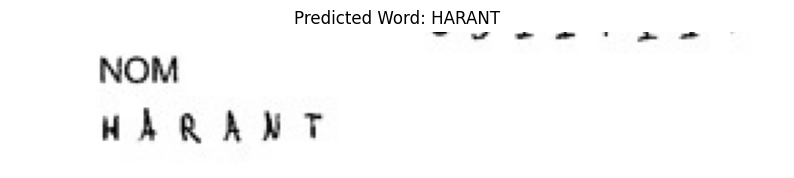

In [14]:
import shutil

# --- Main Execution ---
if __name__ == '__main__':
    # This check prevents running the training automatically when the script is imported.
    # To train the model, uncomment the following line in your Colab notebook.

    # Define the device to be used for training and prediction
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # To store prediction_model
    prediction_model = None

    # Load model from file if exists
    if os.path.exists(config.MODEL_SAVE_PATH):
        print(f"\n--- Model loaded from the file ---")
        prediction_model = mlflow.pytorch.load_model(config.MODEL_SAVE_PATH)
    else:
        best_run_id = finding_best_model()
        if best_run_id is None:
            print("There is no registered run for the model in MLflow's model registry under the Experiment. Starting to train the model.")

            # Setting up the Experiment before starting the training
            mlflow.set_experiment(config.EXPERIMENT_NAME)

            # Run hyperparameter optimization and training
            best_hyperparameters = train_model_with_hyperopt()

            # Finding best model from the runs to use for predictions below
            best_run_id = finding_best_model()

        print(f"Best run ID which is used to get the model for predictions: {best_run_id}")


    # --- Example of how to use the prediction function ---
    # You would need a trained model file ('best_crnn_model.pth') and an image.

    print("\nTo run prediction, you need a trained model.")
    print("First, run the main() function to train and save a model.")
    print("Then, you can use the predict_word() function like this:")
    print("`predict_word(trained_model, 'path/to/your/image.png', device)`")

    # Example usage with a sample image from the validation set
    # Let's find a sample image to test with
    try:
        validation_df_for_pred = pd.read_csv(config.VALIDATION_CSV_PATH).dropna().reset_index(drop=True)
        sample_row = validation_df_for_pred.sample(1).iloc[0]
        sample_img_name = sample_row['FILENAME']
        sample_label = sample_row['IDENTITY']

        sample_img_path = os.path.join(config.DATA_DIR, 'validation_v2/validation', sample_img_name)

        if os.path.exists(sample_img_path):
            print(f"\n--- Running Prediction on a Sample Image ---")
            print(f"Image: {sample_img_name}, True Label: {sample_label}")

            # Load a pre-trained model if it exists, otherwise you need to train first
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


            if prediction_model is None and best_run_id is not None:
                model_uri = f"runs:/{best_run_id}/model"

                print(f"\n--- Downloading Model from best run id ---")
                # This will download the model files (MLmodel, conda.yaml, etc.) into the specified directory
                local_path = mlflow.artifacts.download_artifacts(artifact_uri=model_uri)
                shutil.copytree(local_path, config.MODEL_SAVE_PATH, dirs_exist_ok=True)
                print(f"Model downloaded to: {config.MODEL_SAVE_PATH}")

                # Load model from the best run in the experiment
                prediction_model = mlflow.pytorch.load_model(model_uri)


            if (prediction_model):
                  # Now best_prediction_model is a PyTorch model, ready for inference
                  prediction_model.eval()
                  print(f"\n--- Predicting from MLFlow version of the model ---")
                  predict_word(prediction_model, sample_img_path, device)

            else:
                print("No model found in MLflow's model registry.")
                # Get the best rnn_layers from the hyperparameter search results
                best_rnn_layers = hyperopt.space_eval(search_space, best_hyperparameters)['rnn_layers']
                best_rnn_hidden_size = hyperopt.space_eval(search_space, best_hyperparameters)['rnn_hidden_size']

                # Instantiate the model with the best hyperparameters
                prediction_model = CRNN(img_channels=1, vocab_size=config.VOCAB_SIZE,
                                        rnn_hidden_size=best_rnn_hidden_size,
                                        rnn_layers=best_rnn_layers).to(device)
                if os.path.exists(config.MODEL_SAVE_PATH):
                    prediction_model.load_state_dict(torch.load(config.MODEL_SAVE_PATH, map_location=device))
                    predict_word(prediction_model, sample_img_path, device)
                else:
                    print(f"\nCould not find {config.MODEL_SAVE_PATH}.")
                    print("Please train the model first by uncommenting and running `trained_model = main()`")


        else:
            print(f"Could not find sample image at: {sample_img_path}")

    except FileNotFoundError:
        print("\nCould not find validation CSV. Please ensure the dataset is downloaded and extracted correctly.")
    except RuntimeError as e:
        print(f"An error occurred during model loading or prediction: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")